# Stock Market Analysis

Time Series data is a series of data points indexed in time order. Time series data is everywhere, so manipulating them is important for any data analyst or data scientist.

In this notebook, we will discover and explore data from the stock market, particularly some technology stocks (Apple, Amazon, Google, and Microsoft). We will learn how to use yfinance to get stock information, and visualize different aspects of it using Seaborn and Matplotlib. we will look at a few ways of analyzing the risk of a stock, based on its previous performance history. We will also be predicting future stock prices through a Long Short Term Memory (LSTM) method!

We'll be answering the following questions along the way:

1.) What was the change in price of the stock over time?

2.) What was the daily return of the stock on average?

3.) What was the moving average of the various stocks?

4.) What was the correlation between different stocks'?

5.) How much value do we put at risk by investing in a particular stock?

6.) How can we attempt to predict future stock behavior? (Predicting the closing price stock price of APPLE inc using LSTM)

Getting the Data
The first step is to get the data and load it to memory. We will get our stock data from the Yahoo Finance website. Yahoo Finance is a rich resource of financial market data and tools to find compelling investments. To get the data from Yahoo Finance, we will be using yfinance library which offers a threaded and Pythonic way to download market data from Yahoo. Check this article to learn more about yfinance: [Reliably download historical market data from with Python](/https://aroussi.com/post/python-yahoo-finance)

In [61]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import yfinance 

In [62]:
# Fetch data
tickers = ['AAPL', 'AMZN', 'GOOGL', 'MSFT']
start_date = '2015-01-01'
end_date = '2024-01-01'

data = yf.download(tickers, start=start_date, end=end_date)
data = data['Adj Close']
data.head()


[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2015-01-02,24.402174,15.4260,26.477501,40.305378
2015-01-05,23.714722,15.1095,25.973000,39.934727
2015-01-06,23.716961,14.7645,25.332001,39.348602
2015-01-07,24.049517,14.9210,25.257500,39.848534
2015-01-08,24.973555,15.0230,25.345501,41.020802


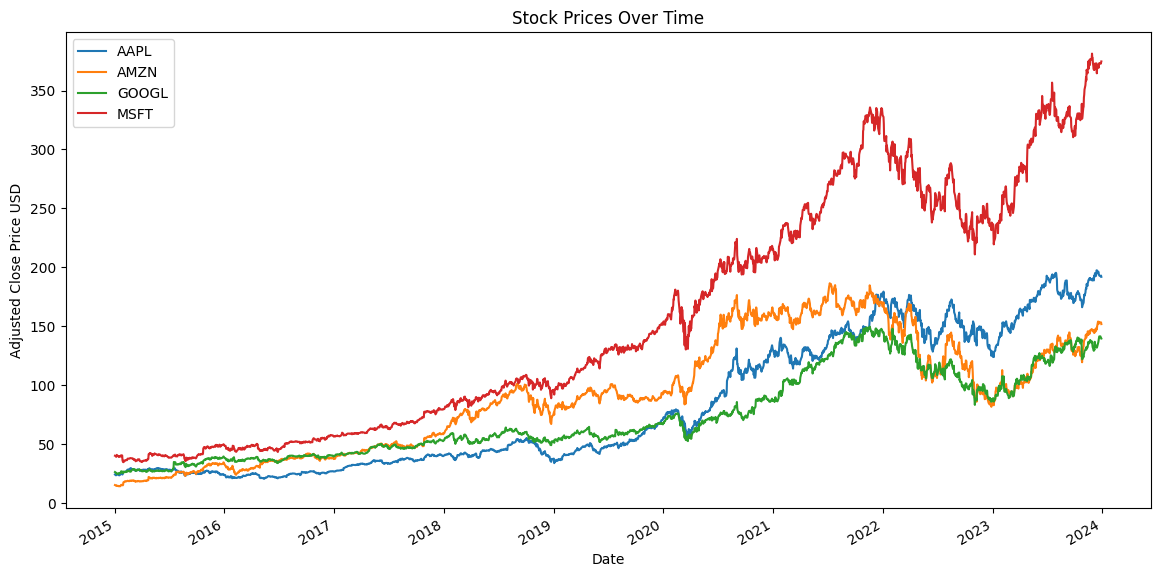

In [63]:
# visualize Stock Pries 
# 1.) What was the change in price of the stock over time?
plt.figure(figsize=(14, 7))
for ticker in tickers:
    data[ticker].plot(label=ticker)
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price USD')
plt.legend()
plt.show()


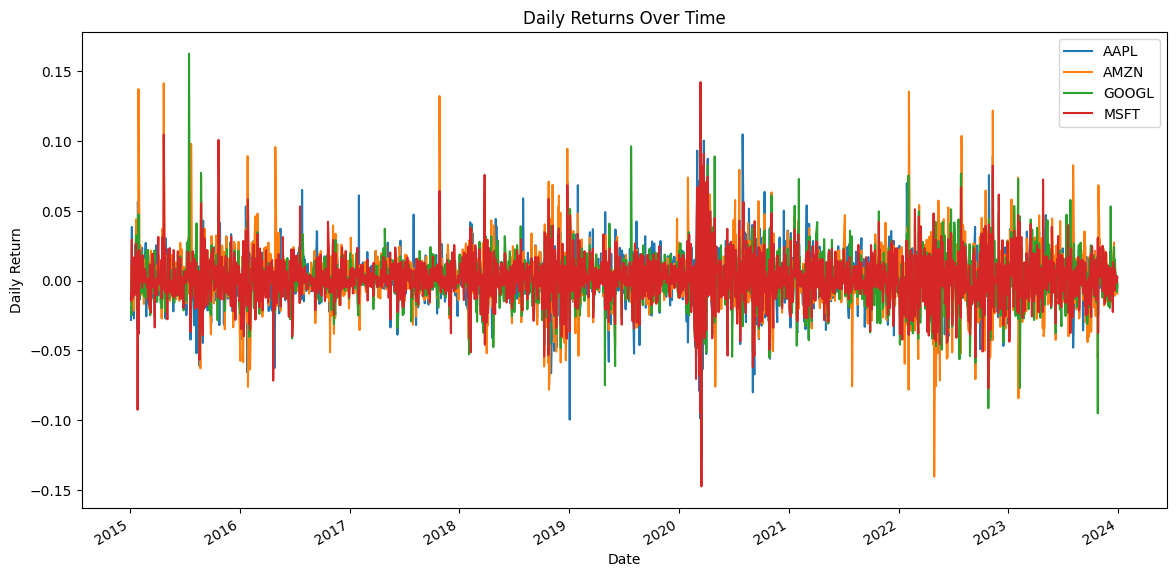

In [64]:
# 2.) What was the daily return of the stock on average?
# Daily Returns
# Calculate and visualize daily returns
daily_returns = data.pct_change()
plt.figure(figsize=(14, 7))
for ticker in tickers:
    daily_returns[ticker].plot(label=ticker)
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()


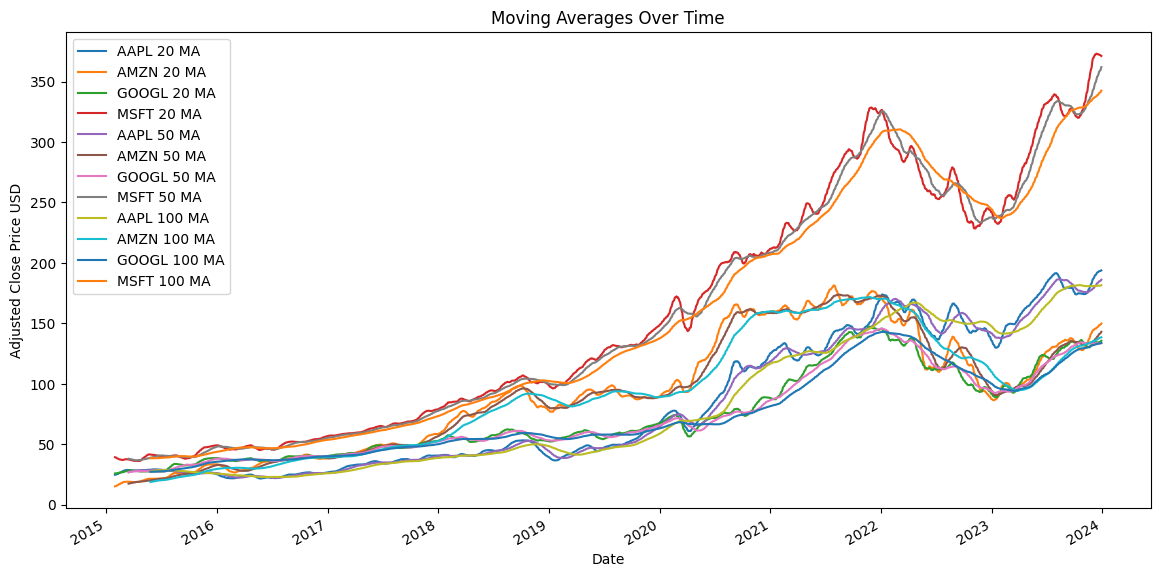

In [65]:
# 3.) What was the moving average of the various stocks?
# Moving Averages
moving_avg_days = [20, 50, 100]
plt.figure(figsize=(14, 7))
for ma in moving_avg_days:
    for ticker in tickers:
        data[f'{ticker} {ma} MA'] = data[ticker].rolling(window=ma).mean()
        data[f'{ticker} {ma} MA'].plot(label=f'{ticker} {ma} MA')
plt.title('Moving Averages Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price USD')
plt.legend()
plt.show()


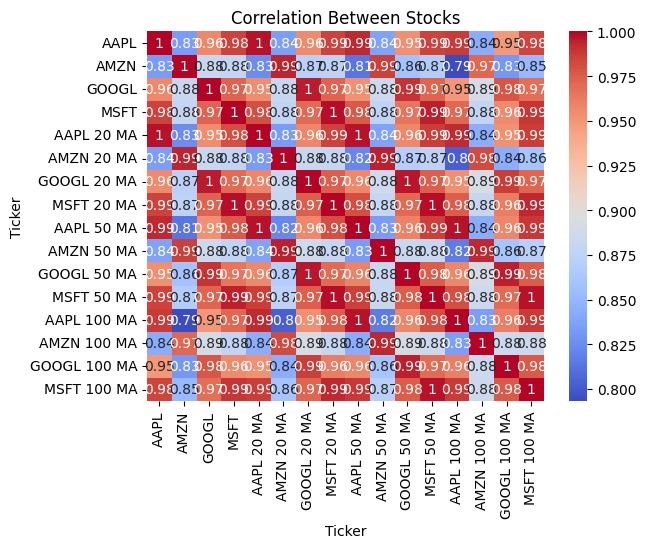

In [66]:
# 4.) What was the correlation between different stocks'?
# Correlation Analysis
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Stocks')
plt.show()


In [67]:
# 5.) How much value do we put at risk by investing in a particular stock?
# Value at Risk (VaR)
VaR = daily_returns.quantile(0.05)
print("Value at Risk (VaR) at 5% Confidence Level")
print(VaR)


Value at Risk (VaR) at 5% Confidence Level
Ticker
AAPL    -0.027484
AMZN    -0.031549
GOOGL   -0.026748
MSFT    -0.026763
Name: 0.05, dtype: float64


2091/2091 ━━━━━━━━━━━━━━━━━━━━ 44s 20ms/step - loss: 0.0026
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


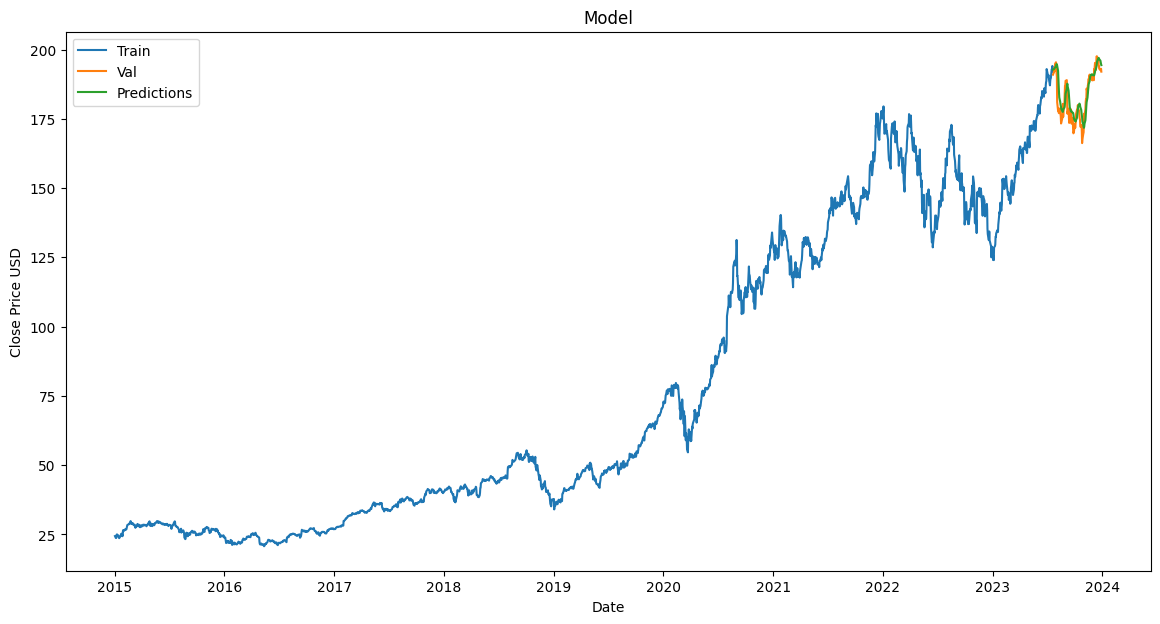

In [72]:
# 6.) How can we attempt to predict future stock behavior? (Predicting the closing price stock price of APPLE inc using LSTM)
#  Predicting Future Prices with LSTM
# Prepare data for LSTM:
df = data[['AAPL']].dropna()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

train_data_len = int(np.ceil(len(scaled_data) * .95))
train_data = scaled_data[:train_data_len, :]

x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

from tensorflow.keras.layers import Input

model = Sequential()
model.add(Input(shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Preparing test data
test_data = scaled_data[train_data_len - 60:, :]
x_test = []
y_test = df[train_data_len:].values
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Making predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Validating predictions
valid = df[train_data_len:].copy()  # Create a copy to avoid the warning
valid.loc[:, 'Predictions'] = predictions

# Plotting the results
plt.figure(figsize=(14, 7))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['AAPL'])
plt.plot(valid[['AAPL', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

